# Breast Dataset

In [1]:
import sys  
sys.path.insert(0, '../')
import deep_forest
import preprocess
import torch as th
from torch import nn as nn
import matplotlib.pyplot as plt
%matplotlib inline
from math import pi
import seaborn as sns
from tqdm import tqdm
sns.set_theme("notebook")
sns.set_style('whitegrid')

## Generate Data

In [2]:
x, y, _, _ = preprocess.get_data(100)

## Deep Forest

In [3]:
model = deep_forest.DeepForest(100, 2, 30, 0.25, 10)
device = th.device("cuda" if th.cuda.is_available() else "cpu")
model = model.to(device)
x = x.to(device)
y = y.to(device)

In [4]:
%time model.train(2500, x, y)
print("\n==============\nFINAL ACC: %s" % str(th.mean((model.forward(model.trees, x) == y).float())))

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


CPU times: user 1.08 s, sys: 129 ms, total: 1.21 s
Wall time: 5min 14s

FINAL ACC: tensor(0.9772)


In [5]:
imp = model.compute_importance(x)
print()
print(dict(imp))

100%|██████████| 104/104 [12:21<00:00,  7.13s/it]


{17: 0.00141443042666001, 0: 0.05509071514521887, 3: 0.1017467008274084, 26: 0.026420601697055762, 27: 0.03878532609867303, 20: 0.09894430730493829, 10: 0.033110925720816226, 1: 0.016233462424012718, 9: 0.0018014126584130737, 25: 0.02024401484809738, 14: 0.0010249882546399202, 11: 0.010170500343577877, 16: 0.008037846999091859, 13: 0.05988065242191194, 6: 0.04249965056212306, 28: 0.013134780055638338, 24: 0.005970976368426327, 22: 0.1047141646876842, 7: 0.024225635959657287, 5: 0.00886198201868822, 18: 0.0018319400519599728, 15: 0.006352168250462462, 21: 0.02897587757324462, 29: 0.005566778413041483, 12: 0.020664361970130836, 8: 0.002575203147027499, 23: 0.18567643668692677, 4: 0.0031434399776775236, 2: 0.0720160212374451, 19: 0.0008846978693507152}


Text(0.5, 1.0, 'Breast Deep Forest Importance')

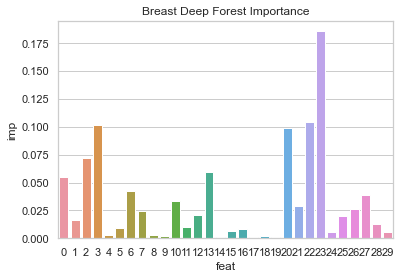

In [6]:
import pandas as pd
data = pd.DataFrame({"feat": list(imp.keys()), "imp": list(imp.values())})
sns.barplot(x="feat", y="imp", data=data).set_title("Breast Deep Forest Importance")

## MLP Baseline

In [7]:
mlp = nn.Sequential(
    nn.Linear(30, 100),
    nn.LeakyReLU(),
    nn.Linear(100, 25),
    nn.LeakyReLU(),
    nn.Linear(25, 2),
    nn.Softmax()
)

optimizer = th.optim.Adam(mlp.parameters())
pbar = tqdm(range(1000))
for i in pbar:
    optimizer.zero_grad()

    preds = mlp(x)
    loss = nn.functional.cross_entropy(preds, y)
    loss.backward()
    optimizer.step()

    pbar.set_description("EPOCH %d || Acc: %s || Loss: %s" % (i, str(th.mean((th.argmax(mlp(x), 1) == y).float())), str(loss)))

print("\n\n==============\nFINAL ACC: %s" % str(th.mean((th.argmax(mlp(x[:]), 1) == y[:]).float())))

  0%|          | 0/1000 [00:00<?, ?it/s]Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
EPOCH 999 || Acc: tensor(0.6274) || Loss: tensor(0.6858, grad_fn=<NllLossBackward>): 100%|██████████| 1000/1000 [00:04<00:00, 215.33it/s]




FINAL ACC: tensor(0.6274)


## Random Forest

In [12]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=2)
clf.fit(x[:, :].numpy(), y[:].numpy())
print(clf.score(x[:, :].numpy(), y[:].numpy()))

0.961335676625659


Text(0.5, 1.0, 'Breast Random Forest Importance')

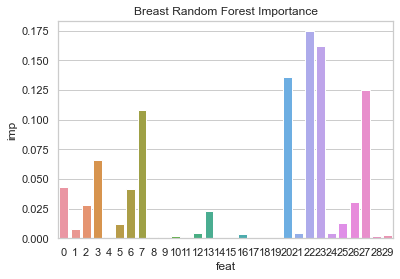

In [13]:
data = pd.DataFrame({"feat": list(range(30)), "imp": clf.feature_importances_})
sns.barplot(x="feat", y="imp", data=data).set_title("Breast Random Forest Importance")